## Import librairies

In [1]:
import torch
import numpy as np 
import os
import pandas as pd
import tqdm 
from tqdm import tqdm, trange

from sklearn.metrics import accuracy_score, confusion_matrix


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from torch.utils.data import WeightedRandomSampler

from utils import run_model_eval, run_model, training_model
from models.cnn import CNNClassifier
from models.mlp import MLP_Classifier
from utils import is_early_stopping
from Data_loader import prepare_data
import json


In [2]:
# Run if File pickle already exists in folder
import pickle

with open('./DeepFake_Real_Sounds.pkl', 'rb') as file:
    data_final = pickle.load(file)


In [26]:
stride=1
padding=0
kernel_size=3
dilation=1
l_in=122
formula=((l_in + 2*padding - dilation*(kernel_size-1)-1)/stride) +1
print(formula)

120.0


In [3]:
from hparams import hparams
hparams.parse_argument(args=["--batch_size", "128"])

-------------------------
Hyper Parameter Settings
-------------------------
batch_size: 128
num_epochs: 100
learning_rate: 0.1
stopping_rate: 1e-05
momentum: 0.6
factor: 0.2
patience: 30
-------------------------


## Train, Test and Eval Splits with a weighted oversampling on the training set

In [4]:
embeddings = np.array(data_final['embedding'].tolist())
labels = (data_final['label']).values



X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.1, random_state=42)

X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.22, random_state=42)


X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_eval_tensor = torch.tensor(X_eval, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1,1)
y_eval_tensor = torch.tensor(y_eval, dtype=torch.float32).view(-1,1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1,1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
eval_dataset = TensorDataset(X_eval_tensor, y_eval_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# DataLoader
batch_size = hparams.batch_size
class_sample_count = np.array([len(np.where(y_train == t)[0]) for t in np.unique(y_train)])
weights = 1. / class_sample_count
samples_weights = np.array([weights[t] for t in y_train])

sampler = WeightedRandomSampler(weights=samples_weights, num_samples=len(samples_weights), replacement=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, sampler=sampler, shuffle=False)
eval_loader = DataLoader(dataset=eval_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

## Ratio of each Class

Here we check that our oversampling in the training set was succesfully done, what is expected is to have a 50/50 distribution of the classes in the training set

In [5]:
count_label_0 = 0
count_label_1 = 0


for _, labels in train_loader:
    count_label_0 += torch.sum(labels == 0)
    count_label_1 += torch.sum(labels == 1)


total_labels = count_label_0 + count_label_1

percentage_label_0 = (count_label_0 / total_labels) * 100
percentage_label_1 = (count_label_1 / total_labels) * 100

print(f"Pourcentage de labels 0 : {percentage_label_0:.2f}%")
print(f"Pourcentage de labels 1 : {percentage_label_1:.2f}%")


Pourcentage de labels 0 : 50.64%
Pourcentage de labels 1 : 49.36%


We then put our system in the GPU mode in order to execute operations in a faster way, the GPU device used here is a RTX 3060 LAPTOP GPU

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Training of the CNNClassifier

In [7]:
from flopth import flopth

model_flops = CNNClassifier()  
input = torch.randn(128,1,128)  


flops, params = flopth(model_flops, inputs=(input,), show_detail=True)
print(f"Flops :{flops}")


In [11]:
from flopth import flopth

model_flops_MLP = MLP_Classifier(128,128*2,1)
input = torch.randn(128,1,128)  


flops_MLP, params = flopth(model_flops_MLP, inputs=(input,), show_detail=True)
print(f"Flops :{flops_MLP}")


+---------------+---------------+------------+-------------+------------------------------+----------+------------------+------------------------+---------+-----------------+--------------------------+
| module_name   | module_type   | in_shape   | out_shape   | kernel_size,padding,stride   | params   | params_percent   | params_percent_vis     | flops   | flops_percent   | flops_percent_vis        |
+===============+===============+============+=============+==============================+==========+==================+========================+=========+=================+==========================+
| linear1       | Linear        | (1,128)    | (1,256)     |                              | 33.024K  | 11.1495%         | #####                  | 128.0   | 0.0972763%      |                          |
+---------------+---------------+------------+-------------+------------------------------+----------+------------------+------------------------+---------+-----------------+------------------

In [9]:
with open('./results_models.json', 'r') as file:
    all_results_json = json.load(file)

## CNN Classifier

In [47]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv1d(in_channels= 1, out_channels= 64,stride=1, kernel_size=3, padding=1,dilation=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=3,stride=1)
        self.conv2 = nn.Conv1d(in_channels= 64, out_channels= 64,stride=1, kernel_size=3, padding=1,dilation=1)
        self.pool2 = nn.MaxPool1d(kernel_size=3,stride=1)
        self.drop = nn.Dropout(0.3)
        self.relu2 = nn.ReLU()
        self.linear = nn.Linear(in_features= 124*64,out_features=1)

    def forward(self, x):  
        x = self.relu1(self.conv1(x)) # 32 x 256 x 128
        x = self.pool1(x)
        x = self.relu2(self.conv2(x)) # 32 x 256 x 128
        x = self.pool2(x)
        x = self.drop(x)
        x = nn.Flatten()(x)
        x = self.linear(x) # 32 x 1
        
        return x # 32 x 2

In [48]:
timings=[]
hparams.parse_argument(args=["--batch_size", "128", "--learning_rate","0.03", "--momentum","0.9"])

model_CNN = CNNClassifier().to(device)
optimizer = optim.SGD(model_CNN.parameters(), lr= hparams.learning_rate,momentum=hparams.momentum)
loss_function = nn.BCEWithLogitsLoss()
scheduler=ReduceLROnPlateau(optimizer, mode='max', factor=hparams.factor, patience=hparams.patience, verbose=True)

train_loss_plot, valid_loss_plot, train_acc_plot, valid_acc_plot,epochs = training_model(optimizer=optimizer,device=device,train_loader=train_loader,test_loader=test_loader,loss_function=loss_function,\
                                                                                 model=model_CNN,flops=flops ,timings=timings, all_results_json=all_results_json,first_execution=True, 
                                                                                 scheduler=scheduler,hparams=hparams,early_stop=False
                                                                                 )



-------------------------
Hyper Parameter Settings
-------------------------
batch_size: 128
num_epochs: 100
learning_rate: 0.03
stopping_rate: 1e-05
momentum: 0.9
factor: 0.2
patience: 30
-------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

WARMING UP FOR GPU


 33%|███▎      | 1/3 [00:01<00:03,  1.58s/it]

WARMING UP FOR GPU


 67%|██████▋   | 2/3 [00:02<00:01,  1.30s/it]

WARMING UP FOR GPU


100%|██████████| 3/3 [00:03<00:00,  1.26s/it]


Training of the model CNNClassifier(
  (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu1): ReLU()
  (pool1): MaxPool1d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool2): MaxPool1d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout(p=0.3, inplace=False)
  (relu2): ReLU()
  (linear): Linear(in_features=7936, out_features=1, bias=True)
) is starting ... :


  1%|          | 1/100 [00:01<02:13,  1.35s/it]

[Epoch 1/100] [Train Loss: 0.5251] [Train Acc: 0.7348] [Valid Loss: 0.4583] [Valid Acc: 0.7657]


  2%|▏         | 2/100 [00:03<02:29,  1.53s/it]

[Epoch 2/100] [Train Loss: 0.5071] [Train Acc: 0.7507] [Valid Loss: 0.3923] [Valid Acc: 0.8209]


  3%|▎         | 3/100 [00:04<02:15,  1.40s/it]

[Epoch 3/100] [Train Loss: 0.4961] [Train Acc: 0.7563] [Valid Loss: 0.4371] [Valid Acc: 0.7817]


  4%|▍         | 4/100 [00:05<02:16,  1.42s/it]

[Epoch 4/100] [Train Loss: 0.4813] [Train Acc: 0.7689] [Valid Loss: 0.4665] [Valid Acc: 0.7794]


  5%|▌         | 5/100 [00:07<02:14,  1.41s/it]

[Epoch 5/100] [Train Loss: 0.4804] [Train Acc: 0.7668] [Valid Loss: 0.4814] [Valid Acc: 0.7489]


  6%|▌         | 6/100 [00:08<02:06,  1.35s/it]

[Epoch 6/100] [Train Loss: 0.4649] [Train Acc: 0.7775] [Valid Loss: 0.4813] [Valid Acc: 0.7569]


  7%|▋         | 7/100 [00:09<02:10,  1.40s/it]

[Epoch 7/100] [Train Loss: 0.4690] [Train Acc: 0.7760] [Valid Loss: 0.4522] [Valid Acc: 0.7738]


  8%|▊         | 8/100 [00:11<02:08,  1.39s/it]

[Epoch 8/100] [Train Loss: 0.4566] [Train Acc: 0.7830] [Valid Loss: 0.3680] [Valid Acc: 0.8222]


  9%|▉         | 9/100 [00:12<02:07,  1.40s/it]

[Epoch 9/100] [Train Loss: 0.4491] [Train Acc: 0.7903] [Valid Loss: 0.4946] [Valid Acc: 0.7516]


 10%|█         | 10/100 [00:14<02:06,  1.40s/it]

[Epoch 10/100] [Train Loss: 0.4458] [Train Acc: 0.7895] [Valid Loss: 0.4505] [Valid Acc: 0.7772]


 11%|█         | 11/100 [00:15<02:08,  1.44s/it]

[Epoch 11/100] [Train Loss: 0.4396] [Train Acc: 0.7963] [Valid Loss: 0.5094] [Valid Acc: 0.7403]


 12%|█▏        | 12/100 [00:17<02:09,  1.47s/it]

[Epoch 12/100] [Train Loss: 0.4434] [Train Acc: 0.7882] [Valid Loss: 0.4317] [Valid Acc: 0.7816]


 13%|█▎        | 13/100 [00:18<02:06,  1.45s/it]

[Epoch 13/100] [Train Loss: 0.4306] [Train Acc: 0.7969] [Valid Loss: 0.3808] [Valid Acc: 0.8200]


 14%|█▍        | 14/100 [00:19<02:01,  1.41s/it]

[Epoch 14/100] [Train Loss: 0.4400] [Train Acc: 0.7900] [Valid Loss: 0.3963] [Valid Acc: 0.8109]


 15%|█▌        | 15/100 [00:21<01:57,  1.38s/it]

[Epoch 15/100] [Train Loss: 0.4414] [Train Acc: 0.7910] [Valid Loss: 0.3687] [Valid Acc: 0.8359]


 16%|█▌        | 16/100 [00:23<02:21,  1.68s/it]

[Epoch 16/100] [Train Loss: 0.4336] [Train Acc: 0.7949] [Valid Loss: 0.4359] [Valid Acc: 0.7891]


 17%|█▋        | 17/100 [00:24<02:08,  1.55s/it]

[Epoch 17/100] [Train Loss: 0.4275] [Train Acc: 0.8010] [Valid Loss: 0.4672] [Valid Acc: 0.7734]


 18%|█▊        | 18/100 [00:26<02:06,  1.54s/it]

[Epoch 18/100] [Train Loss: 0.4288] [Train Acc: 0.8009] [Valid Loss: 0.4257] [Valid Acc: 0.7869]


 19%|█▉        | 19/100 [00:27<01:57,  1.45s/it]

[Epoch 19/100] [Train Loss: 0.4211] [Train Acc: 0.8018] [Valid Loss: 0.4042] [Valid Acc: 0.8072]


 20%|██        | 20/100 [00:28<01:50,  1.38s/it]

[Epoch 20/100] [Train Loss: 0.4207] [Train Acc: 0.8061] [Valid Loss: 0.3658] [Valid Acc: 0.8216]


 21%|██        | 21/100 [00:30<01:49,  1.39s/it]

[Epoch 21/100] [Train Loss: 0.4281] [Train Acc: 0.7993] [Valid Loss: 0.4248] [Valid Acc: 0.7978]


 22%|██▏       | 22/100 [00:31<01:44,  1.34s/it]

[Epoch 22/100] [Train Loss: 0.4174] [Train Acc: 0.8072] [Valid Loss: 0.4496] [Valid Acc: 0.7853]


 23%|██▎       | 23/100 [00:32<01:48,  1.41s/it]

[Epoch 23/100] [Train Loss: 0.4088] [Train Acc: 0.8109] [Valid Loss: 0.4775] [Valid Acc: 0.7606]


 24%|██▍       | 24/100 [00:34<01:59,  1.57s/it]

[Epoch 24/100] [Train Loss: 0.4100] [Train Acc: 0.8100] [Valid Loss: 0.3851] [Valid Acc: 0.8187]


 25%|██▌       | 25/100 [00:36<01:54,  1.53s/it]

[Epoch 25/100] [Train Loss: 0.4115] [Train Acc: 0.8112] [Valid Loss: 0.3404] [Valid Acc: 0.8462]


 26%|██▌       | 26/100 [00:37<01:49,  1.48s/it]

[Epoch 26/100] [Train Loss: 0.4032] [Train Acc: 0.8150] [Valid Loss: 0.4016] [Valid Acc: 0.8003]


 27%|██▋       | 27/100 [00:39<01:47,  1.47s/it]

[Epoch 27/100] [Train Loss: 0.4028] [Train Acc: 0.8124] [Valid Loss: 0.3652] [Valid Acc: 0.8325]


 28%|██▊       | 28/100 [00:40<01:44,  1.45s/it]

[Epoch 28/100] [Train Loss: 0.4014] [Train Acc: 0.8164] [Valid Loss: 0.3958] [Valid Acc: 0.8113]


 29%|██▉       | 29/100 [00:42<01:44,  1.47s/it]

[Epoch 29/100] [Train Loss: 0.4029] [Train Acc: 0.8128] [Valid Loss: 0.4839] [Valid Acc: 0.7656]


 30%|███       | 30/100 [00:43<01:44,  1.49s/it]

[Epoch 30/100] [Train Loss: 0.3895] [Train Acc: 0.8208] [Valid Loss: 0.4103] [Valid Acc: 0.7984]


 31%|███       | 31/100 [00:45<01:45,  1.53s/it]

[Epoch 31/100] [Train Loss: 0.3944] [Train Acc: 0.8204] [Valid Loss: 0.3908] [Valid Acc: 0.8169]


 32%|███▏      | 32/100 [00:46<01:39,  1.47s/it]

[Epoch 32/100] [Train Loss: 0.3900] [Train Acc: 0.8224] [Valid Loss: 0.3725] [Valid Acc: 0.8234]


 33%|███▎      | 33/100 [00:47<01:36,  1.44s/it]

[Epoch 33/100] [Train Loss: 0.3840] [Train Acc: 0.8268] [Valid Loss: 0.4241] [Valid Acc: 0.7941]


 34%|███▍      | 34/100 [00:49<01:31,  1.38s/it]

[Epoch 34/100] [Train Loss: 0.3972] [Train Acc: 0.8184] [Valid Loss: 0.3475] [Valid Acc: 0.8425]


 35%|███▌      | 35/100 [00:50<01:29,  1.38s/it]

[Epoch 35/100] [Train Loss: 0.3891] [Train Acc: 0.8249] [Valid Loss: 0.3849] [Valid Acc: 0.8159]


 36%|███▌      | 36/100 [00:52<01:43,  1.62s/it]

[Epoch 36/100] [Train Loss: 0.3883] [Train Acc: 0.8212] [Valid Loss: 0.3565] [Valid Acc: 0.8400]


 37%|███▋      | 37/100 [00:54<01:39,  1.59s/it]

[Epoch 37/100] [Train Loss: 0.3864] [Train Acc: 0.8269] [Valid Loss: 0.3962] [Valid Acc: 0.8150]


 38%|███▊      | 38/100 [00:55<01:36,  1.56s/it]

[Epoch 38/100] [Train Loss: 0.3883] [Train Acc: 0.8252] [Valid Loss: 0.3928] [Valid Acc: 0.8156]


 39%|███▉      | 39/100 [00:56<01:29,  1.46s/it]

[Epoch 39/100] [Train Loss: 0.3761] [Train Acc: 0.8289] [Valid Loss: 0.3424] [Valid Acc: 0.8384]


 40%|████      | 40/100 [00:58<01:28,  1.47s/it]

[Epoch 40/100] [Train Loss: 0.3781] [Train Acc: 0.8290] [Valid Loss: 0.3918] [Valid Acc: 0.8122]


 41%|████      | 41/100 [00:59<01:23,  1.42s/it]

[Epoch 41/100] [Train Loss: 0.3746] [Train Acc: 0.8344] [Valid Loss: 0.3978] [Valid Acc: 0.8166]


 42%|████▏     | 42/100 [01:01<01:20,  1.39s/it]

[Epoch 42/100] [Train Loss: 0.3749] [Train Acc: 0.8340] [Valid Loss: 0.3793] [Valid Acc: 0.8244]


 43%|████▎     | 43/100 [01:02<01:19,  1.39s/it]

[Epoch 43/100] [Train Loss: 0.3745] [Train Acc: 0.8330] [Valid Loss: 0.4148] [Valid Acc: 0.8103]


 44%|████▍     | 44/100 [01:03<01:17,  1.39s/it]

[Epoch 44/100] [Train Loss: 0.3756] [Train Acc: 0.8325] [Valid Loss: 0.3602] [Valid Acc: 0.8403]


 45%|████▌     | 45/100 [01:05<01:16,  1.40s/it]

[Epoch 45/100] [Train Loss: 0.3761] [Train Acc: 0.8331] [Valid Loss: 0.4361] [Valid Acc: 0.7947]


 46%|████▌     | 46/100 [01:06<01:15,  1.41s/it]

[Epoch 46/100] [Train Loss: 0.3667] [Train Acc: 0.8353] [Valid Loss: 0.3687] [Valid Acc: 0.8325]


 47%|████▋     | 47/100 [01:08<01:13,  1.39s/it]

[Epoch 47/100] [Train Loss: 0.3665] [Train Acc: 0.8363] [Valid Loss: 0.3808] [Valid Acc: 0.8213]


 48%|████▊     | 48/100 [01:09<01:14,  1.42s/it]

[Epoch 48/100] [Train Loss: 0.3722] [Train Acc: 0.8323] [Valid Loss: 0.4671] [Valid Acc: 0.7731]


 49%|████▉     | 49/100 [01:11<01:15,  1.47s/it]

[Epoch 49/100] [Train Loss: 0.3613] [Train Acc: 0.8395] [Valid Loss: 0.3470] [Valid Acc: 0.8459]


 50%|█████     | 50/100 [01:12<01:11,  1.43s/it]

[Epoch 50/100] [Train Loss: 0.3629] [Train Acc: 0.8409] [Valid Loss: 0.3299] [Valid Acc: 0.8472]


 51%|█████     | 51/100 [01:13<01:08,  1.39s/it]

[Epoch 51/100] [Train Loss: 0.3631] [Train Acc: 0.8358] [Valid Loss: 0.3717] [Valid Acc: 0.8328]


 52%|█████▏    | 52/100 [01:15<01:10,  1.46s/it]

[Epoch 52/100] [Train Loss: 0.3577] [Train Acc: 0.8414] [Valid Loss: 0.3511] [Valid Acc: 0.8369]


 53%|█████▎    | 53/100 [01:16<01:07,  1.43s/it]

[Epoch 53/100] [Train Loss: 0.3659] [Train Acc: 0.8378] [Valid Loss: 0.3470] [Valid Acc: 0.8441]


 54%|█████▍    | 54/100 [01:18<01:04,  1.41s/it]

[Epoch 54/100] [Train Loss: 0.3539] [Train Acc: 0.8434] [Valid Loss: 0.3160] [Valid Acc: 0.8556]


 55%|█████▌    | 55/100 [01:19<01:04,  1.42s/it]

[Epoch 55/100] [Train Loss: 0.3533] [Train Acc: 0.8449] [Valid Loss: 0.4062] [Valid Acc: 0.8116]


 56%|█████▌    | 56/100 [01:20<01:00,  1.38s/it]

[Epoch 56/100] [Train Loss: 0.3556] [Train Acc: 0.8412] [Valid Loss: 0.4167] [Valid Acc: 0.8097]


 57%|█████▋    | 57/100 [01:23<01:10,  1.63s/it]

[Epoch 57/100] [Train Loss: 0.3523] [Train Acc: 0.8436] [Valid Loss: 0.3500] [Valid Acc: 0.8347]


 58%|█████▊    | 58/100 [01:24<01:03,  1.52s/it]

[Epoch 58/100] [Train Loss: 0.3507] [Train Acc: 0.8460] [Valid Loss: 0.3327] [Valid Acc: 0.8550]


 59%|█████▉    | 59/100 [01:25<01:01,  1.50s/it]

[Epoch 59/100] [Train Loss: 0.3502] [Train Acc: 0.8481] [Valid Loss: 0.4306] [Valid Acc: 0.8106]


 60%|██████    | 60/100 [01:27<00:59,  1.48s/it]

[Epoch 60/100] [Train Loss: 0.3486] [Train Acc: 0.8473] [Valid Loss: 0.3398] [Valid Acc: 0.8459]


 61%|██████    | 61/100 [01:28<00:54,  1.40s/it]

[Epoch 61/100] [Train Loss: 0.3484] [Train Acc: 0.8438] [Valid Loss: 0.3899] [Valid Acc: 0.8263]


 62%|██████▏   | 62/100 [01:29<00:52,  1.39s/it]

[Epoch 62/100] [Train Loss: 0.3521] [Train Acc: 0.8441] [Valid Loss: 0.3850] [Valid Acc: 0.8287]


 63%|██████▎   | 63/100 [01:31<00:51,  1.39s/it]

[Epoch 63/100] [Train Loss: 0.3433] [Train Acc: 0.8460] [Valid Loss: 0.3635] [Valid Acc: 0.8369]


 64%|██████▍   | 64/100 [01:32<00:48,  1.35s/it]

[Epoch 64/100] [Train Loss: 0.3488] [Train Acc: 0.8474] [Valid Loss: 0.3983] [Valid Acc: 0.8225]


 65%|██████▌   | 65/100 [01:33<00:48,  1.40s/it]

[Epoch 65/100] [Train Loss: 0.3494] [Train Acc: 0.8468] [Valid Loss: 0.3837] [Valid Acc: 0.8209]


 66%|██████▌   | 66/100 [01:35<00:47,  1.40s/it]

[Epoch 66/100] [Train Loss: 0.3400] [Train Acc: 0.8512] [Valid Loss: 0.3978] [Valid Acc: 0.8153]


 67%|██████▋   | 67/100 [01:36<00:46,  1.41s/it]

[Epoch 67/100] [Train Loss: 0.3467] [Train Acc: 0.8486] [Valid Loss: 0.3334] [Valid Acc: 0.8506]


 68%|██████▊   | 68/100 [01:38<00:43,  1.37s/it]

[Epoch 68/100] [Train Loss: 0.3531] [Train Acc: 0.8450] [Valid Loss: 0.3488] [Valid Acc: 0.8409]


 69%|██████▉   | 69/100 [01:39<00:43,  1.39s/it]

[Epoch 69/100] [Train Loss: 0.3343] [Train Acc: 0.8540] [Valid Loss: 0.4426] [Valid Acc: 0.7906]


 70%|███████   | 70/100 [01:40<00:41,  1.38s/it]

[Epoch 70/100] [Train Loss: 0.3427] [Train Acc: 0.8507] [Valid Loss: 0.4373] [Valid Acc: 0.8000]


 71%|███████   | 71/100 [01:42<00:39,  1.37s/it]

[Epoch 71/100] [Train Loss: 0.3431] [Train Acc: 0.8477] [Valid Loss: 0.3313] [Valid Acc: 0.8503]


 72%|███████▏  | 72/100 [01:43<00:39,  1.40s/it]

[Epoch 72/100] [Train Loss: 0.3385] [Train Acc: 0.8514] [Valid Loss: 0.3603] [Valid Acc: 0.8356]


 73%|███████▎  | 73/100 [01:45<00:38,  1.41s/it]

[Epoch 73/100] [Train Loss: 0.3419] [Train Acc: 0.8503] [Valid Loss: 0.3837] [Valid Acc: 0.8253]


 74%|███████▍  | 74/100 [01:46<00:37,  1.45s/it]

[Epoch 74/100] [Train Loss: 0.3380] [Train Acc: 0.8492] [Valid Loss: 0.3951] [Valid Acc: 0.8191]


 75%|███████▌  | 75/100 [01:48<00:35,  1.44s/it]

[Epoch 75/100] [Train Loss: 0.3282] [Train Acc: 0.8588] [Valid Loss: 0.3517] [Valid Acc: 0.8428]


 76%|███████▌  | 76/100 [01:49<00:33,  1.39s/it]

[Epoch 76/100] [Train Loss: 0.3263] [Train Acc: 0.8573] [Valid Loss: 0.3761] [Valid Acc: 0.8325]


 77%|███████▋  | 77/100 [01:50<00:31,  1.39s/it]

[Epoch 77/100] [Train Loss: 0.3307] [Train Acc: 0.8547] [Valid Loss: 0.3174] [Valid Acc: 0.8575]


 78%|███████▊  | 78/100 [01:52<00:35,  1.61s/it]

[Epoch 78/100] [Train Loss: 0.3247] [Train Acc: 0.8585] [Valid Loss: 0.4791] [Valid Acc: 0.7909]


 79%|███████▉  | 79/100 [01:54<00:31,  1.51s/it]

[Epoch 79/100] [Train Loss: 0.3307] [Train Acc: 0.8574] [Valid Loss: 0.4254] [Valid Acc: 0.8025]


 80%|████████  | 80/100 [01:55<00:30,  1.51s/it]

[Epoch 80/100] [Train Loss: 0.3220] [Train Acc: 0.8595] [Valid Loss: 0.3616] [Valid Acc: 0.8278]


 81%|████████  | 81/100 [01:56<00:27,  1.46s/it]

[Epoch 81/100] [Train Loss: 0.3213] [Train Acc: 0.8615] [Valid Loss: 0.3551] [Valid Acc: 0.8431]


 82%|████████▏ | 82/100 [01:58<00:26,  1.47s/it]

[Epoch 82/100] [Train Loss: 0.3313] [Train Acc: 0.8561] [Valid Loss: 0.4285] [Valid Acc: 0.8069]


 83%|████████▎ | 83/100 [01:59<00:24,  1.43s/it]

[Epoch 83/100] [Train Loss: 0.3259] [Train Acc: 0.8581] [Valid Loss: 0.3832] [Valid Acc: 0.8309]


 84%|████████▍ | 84/100 [02:01<00:22,  1.41s/it]

[Epoch 84/100] [Train Loss: 0.3279] [Train Acc: 0.8562] [Valid Loss: 0.3634] [Valid Acc: 0.8438]


 85%|████████▌ | 85/100 [02:02<00:21,  1.41s/it]

[Epoch 85/100] [Train Loss: 0.3247] [Train Acc: 0.8591] [Valid Loss: 0.3438] [Valid Acc: 0.8438]


 86%|████████▌ | 86/100 [02:03<00:19,  1.37s/it]

[Epoch 86/100] [Train Loss: 0.3274] [Train Acc: 0.8590] [Valid Loss: 0.3476] [Valid Acc: 0.8409]


 87%|████████▋ | 87/100 [02:05<00:17,  1.36s/it]

[Epoch 87/100] [Train Loss: 0.3228] [Train Acc: 0.8583] [Valid Loss: 0.4162] [Valid Acc: 0.8122]


 88%|████████▊ | 88/100 [02:06<00:17,  1.43s/it]

[Epoch 88/100] [Train Loss: 0.3212] [Train Acc: 0.8594] [Valid Loss: 0.4101] [Valid Acc: 0.8153]


 89%|████████▉ | 89/100 [02:08<00:15,  1.42s/it]

[Epoch 89/100] [Train Loss: 0.3171] [Train Acc: 0.8615] [Valid Loss: 0.3247] [Valid Acc: 0.8553]


 90%|█████████ | 90/100 [02:09<00:13,  1.37s/it]

[Epoch 90/100] [Train Loss: 0.3082] [Train Acc: 0.8676] [Valid Loss: 0.3632] [Valid Acc: 0.8391]


 91%|█████████ | 91/100 [02:10<00:12,  1.43s/it]

[Epoch 91/100] [Train Loss: 0.3127] [Train Acc: 0.8641] [Valid Loss: 0.3210] [Valid Acc: 0.8612]


 92%|█████████▏| 92/100 [02:12<00:11,  1.41s/it]

[Epoch 92/100] [Train Loss: 0.3043] [Train Acc: 0.8690] [Valid Loss: 0.4456] [Valid Acc: 0.8041]


 93%|█████████▎| 93/100 [02:13<00:09,  1.41s/it]

[Epoch 93/100] [Train Loss: 0.3121] [Train Acc: 0.8604] [Valid Loss: 0.3401] [Valid Acc: 0.8484]


 94%|█████████▍| 94/100 [02:15<00:08,  1.42s/it]

[Epoch 94/100] [Train Loss: 0.3132] [Train Acc: 0.8649] [Valid Loss: 0.3535] [Valid Acc: 0.8434]


 95%|█████████▌| 95/100 [02:16<00:07,  1.42s/it]

[Epoch 95/100] [Train Loss: 0.3090] [Train Acc: 0.8678] [Valid Loss: 0.3991] [Valid Acc: 0.8244]


 96%|█████████▌| 96/100 [02:18<00:05,  1.44s/it]

[Epoch 96/100] [Train Loss: 0.3144] [Train Acc: 0.8637] [Valid Loss: 0.3732] [Valid Acc: 0.8400]


 97%|█████████▋| 97/100 [02:19<00:04,  1.41s/it]

[Epoch 97/100] [Train Loss: 0.3075] [Train Acc: 0.8656] [Valid Loss: 0.3259] [Valid Acc: 0.8525]


 98%|█████████▊| 98/100 [02:20<00:02,  1.38s/it]

[Epoch 98/100] [Train Loss: 0.3052] [Train Acc: 0.8690] [Valid Loss: 0.3528] [Valid Acc: 0.8469]


 99%|█████████▉| 99/100 [02:22<00:01,  1.63s/it]

[Epoch 99/100] [Train Loss: 0.3137] [Train Acc: 0.8622] [Valid Loss: 0.3025] [Valid Acc: 0.8669]


100%|██████████| 100/100 [02:24<00:00,  1.44s/it]

[Epoch 100/100] [Train Loss: 0.3045] [Train Acc: 0.8682] [Valid Loss: 0.3255] [Valid Acc: 0.8544]
Total time of training (only inference time) is 41037.85197329521 and Time per epoch is : 0.41037851973295214 s/epoch


## MLP Classifier

In [13]:
timings=[]

model_MLP = MLP_Classifier(128,128*2,1).to(device)
optimizer = optim.SGD(model_MLP.parameters(), lr= hparams.learning_rate,momentum=hparams.momentum)
loss_function = nn.BCEWithLogitsLoss()
scheduler=ReduceLROnPlateau(optimizer, mode='max', factor=hparams.factor, patience=hparams.patience, verbose=True)

train_loss_plot, valid_loss_plot, train_acc_plot, valid_acc_plot,epochs = training_model(optimizer=optimizer,device=device,train_loader=train_loader,test_loader=test_loader,loss_function=loss_function,\
                                                                                 model=model_MLP,flops=flops_MLP ,timings=timings, all_results_json=all_results_json,first_execution=True, 
                                                                                 scheduler=scheduler,hparams=hparams,early_stop= False
                                                                                 )



  0%|          | 0/3 [00:00<?, ?it/s]

WARMING UP FOR GPU


 33%|███▎      | 1/3 [00:01<00:02,  1.06s/it]

WARMING UP FOR GPU


 67%|██████▋   | 2/3 [00:02<00:01,  1.12s/it]

WARMING UP FOR GPU


100%|██████████| 3/3 [00:03<00:00,  1.18s/it]


Training of the model MLP_Classifier(
  (linear1): Linear(in_features=128, out_features=256, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (linear2): Linear(in_features=256, out_features=512, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (linear3): Linear(in_features=512, out_features=256, bias=True)
  (relu3): ReLU()
  (dropout3): Dropout(p=0.5, inplace=False)
  (linear4): Linear(in_features=256, out_features=1, bias=True)
) is starting ... :


  1%|          | 1/100 [00:01<02:44,  1.66s/it]

[Epoch 1/100] [Train Loss: 0.4959] [Train Acc: 0.7597] [Valid Loss: 0.3757] [Valid Acc: 0.8057]


  2%|▏         | 2/100 [00:03<02:38,  1.61s/it]

[Epoch 2/100] [Train Loss: 0.4864] [Train Acc: 0.7679] [Valid Loss: 0.4467] [Valid Acc: 0.7451]


  3%|▎         | 3/100 [00:04<02:30,  1.55s/it]

[Epoch 3/100] [Train Loss: 0.4667] [Train Acc: 0.7799] [Valid Loss: 0.4427] [Valid Acc: 0.7439]


  4%|▍         | 4/100 [00:06<02:24,  1.51s/it]

[Epoch 4/100] [Train Loss: 0.4600] [Train Acc: 0.7839] [Valid Loss: 0.5463] [Valid Acc: 0.6751]


  5%|▌         | 5/100 [00:07<02:28,  1.57s/it]

[Epoch 5/100] [Train Loss: 0.4442] [Train Acc: 0.7926] [Valid Loss: 0.3884] [Valid Acc: 0.7823]


  6%|▌         | 6/100 [00:09<02:28,  1.58s/it]

[Epoch 6/100] [Train Loss: 0.4355] [Train Acc: 0.7962] [Valid Loss: 0.4196] [Valid Acc: 0.7664]


  7%|▋         | 7/100 [00:11<02:30,  1.62s/it]

[Epoch 7/100] [Train Loss: 0.4323] [Train Acc: 0.8023] [Valid Loss: 0.3718] [Valid Acc: 0.7885]


  8%|▊         | 8/100 [00:13<02:36,  1.70s/it]

[Epoch 8/100] [Train Loss: 0.4276] [Train Acc: 0.8011] [Valid Loss: 0.4167] [Valid Acc: 0.7554]


  9%|▉         | 9/100 [00:14<02:27,  1.62s/it]

[Epoch 9/100] [Train Loss: 0.4215] [Train Acc: 0.8051] [Valid Loss: 0.4999] [Valid Acc: 0.7201]


 10%|█         | 10/100 [00:15<02:15,  1.50s/it]

[Epoch 10/100] [Train Loss: 0.4128] [Train Acc: 0.8093] [Valid Loss: 0.4462] [Valid Acc: 0.7442]


 11%|█         | 11/100 [00:17<02:11,  1.47s/it]

[Epoch 11/100] [Train Loss: 0.4049] [Train Acc: 0.8113] [Valid Loss: 0.3682] [Valid Acc: 0.8106]


 12%|█▏        | 12/100 [00:18<02:03,  1.40s/it]

[Epoch 12/100] [Train Loss: 0.4066] [Train Acc: 0.8145] [Valid Loss: 0.3437] [Valid Acc: 0.8222]


 13%|█▎        | 13/100 [00:19<01:58,  1.36s/it]

[Epoch 13/100] [Train Loss: 0.4003] [Train Acc: 0.8174] [Valid Loss: 0.4297] [Valid Acc: 0.7575]


 14%|█▍        | 14/100 [00:21<01:59,  1.39s/it]

[Epoch 14/100] [Train Loss: 0.4011] [Train Acc: 0.8168] [Valid Loss: 0.3582] [Valid Acc: 0.8094]


 15%|█▌        | 15/100 [00:22<01:53,  1.34s/it]

[Epoch 15/100] [Train Loss: 0.3938] [Train Acc: 0.8224] [Valid Loss: 0.3745] [Valid Acc: 0.8069]


 16%|█▌        | 16/100 [00:23<01:50,  1.31s/it]

[Epoch 16/100] [Train Loss: 0.3878] [Train Acc: 0.8262] [Valid Loss: 0.4163] [Valid Acc: 0.7822]


 17%|█▋        | 17/100 [00:24<01:43,  1.25s/it]

[Epoch 17/100] [Train Loss: 0.3811] [Train Acc: 0.8266] [Valid Loss: 0.3291] [Valid Acc: 0.8272]


 18%|█▊        | 18/100 [00:26<02:02,  1.50s/it]

[Epoch 18/100] [Train Loss: 0.3747] [Train Acc: 0.8308] [Valid Loss: 0.3926] [Valid Acc: 0.7931]


 19%|█▉        | 19/100 [00:27<01:54,  1.42s/it]

[Epoch 19/100] [Train Loss: 0.3785] [Train Acc: 0.8296] [Valid Loss: 0.3199] [Valid Acc: 0.8363]


 20%|██        | 20/100 [00:29<02:04,  1.55s/it]

[Epoch 20/100] [Train Loss: 0.3695] [Train Acc: 0.8350] [Valid Loss: 0.3479] [Valid Acc: 0.8197]


 21%|██        | 21/100 [00:32<02:21,  1.80s/it]

[Epoch 21/100] [Train Loss: 0.3702] [Train Acc: 0.8371] [Valid Loss: 0.3173] [Valid Acc: 0.8391]


 22%|██▏       | 22/100 [00:34<02:21,  1.81s/it]

[Epoch 22/100] [Train Loss: 0.3704] [Train Acc: 0.8319] [Valid Loss: 0.3226] [Valid Acc: 0.8353]


 23%|██▎       | 23/100 [00:35<02:09,  1.68s/it]

[Epoch 23/100] [Train Loss: 0.3673] [Train Acc: 0.8353] [Valid Loss: 0.3723] [Valid Acc: 0.8013]


 24%|██▍       | 24/100 [00:36<02:01,  1.60s/it]

[Epoch 24/100] [Train Loss: 0.3612] [Train Acc: 0.8391] [Valid Loss: 0.3220] [Valid Acc: 0.8334]


 25%|██▌       | 25/100 [00:38<02:04,  1.66s/it]

[Epoch 25/100] [Train Loss: 0.3517] [Train Acc: 0.8432] [Valid Loss: 0.3267] [Valid Acc: 0.8316]


 26%|██▌       | 26/100 [00:40<02:02,  1.65s/it]

[Epoch 26/100] [Train Loss: 0.3494] [Train Acc: 0.8462] [Valid Loss: 0.3073] [Valid Acc: 0.8456]


 27%|██▋       | 27/100 [00:41<01:55,  1.59s/it]

[Epoch 27/100] [Train Loss: 0.3473] [Train Acc: 0.8452] [Valid Loss: 0.3484] [Valid Acc: 0.8216]


 28%|██▊       | 28/100 [00:43<01:56,  1.62s/it]

[Epoch 28/100] [Train Loss: 0.3464] [Train Acc: 0.8477] [Valid Loss: 0.3387] [Valid Acc: 0.8266]


 29%|██▉       | 29/100 [00:45<02:00,  1.70s/it]

[Epoch 29/100] [Train Loss: 0.3401] [Train Acc: 0.8493] [Valid Loss: 0.3192] [Valid Acc: 0.8353]


 30%|███       | 30/100 [00:47<02:13,  1.91s/it]

[Epoch 30/100] [Train Loss: 0.3425] [Train Acc: 0.8487] [Valid Loss: 0.3563] [Valid Acc: 0.8119]


 31%|███       | 31/100 [00:48<01:57,  1.71s/it]

[Epoch 31/100] [Train Loss: 0.3352] [Train Acc: 0.8535] [Valid Loss: 0.3383] [Valid Acc: 0.8278]


 32%|███▏      | 32/100 [00:50<01:49,  1.61s/it]

[Epoch 32/100] [Train Loss: 0.3383] [Train Acc: 0.8490] [Valid Loss: 0.2800] [Valid Acc: 0.8597]


 33%|███▎      | 33/100 [00:51<01:45,  1.57s/it]

[Epoch 33/100] [Train Loss: 0.3269] [Train Acc: 0.8572] [Valid Loss: 0.3078] [Valid Acc: 0.8512]


 34%|███▍      | 34/100 [00:53<01:40,  1.53s/it]

[Epoch 34/100] [Train Loss: 0.3338] [Train Acc: 0.8555] [Valid Loss: 0.3630] [Valid Acc: 0.8163]


 35%|███▌      | 35/100 [00:54<01:35,  1.47s/it]

[Epoch 35/100] [Train Loss: 0.3307] [Train Acc: 0.8576] [Valid Loss: 0.2993] [Valid Acc: 0.8481]


 36%|███▌      | 36/100 [00:56<01:48,  1.70s/it]

[Epoch 36/100] [Train Loss: 0.3257] [Train Acc: 0.8574] [Valid Loss: 0.2965] [Valid Acc: 0.8522]


 37%|███▋      | 37/100 [00:58<01:51,  1.78s/it]

[Epoch 37/100] [Train Loss: 0.3249] [Train Acc: 0.8593] [Valid Loss: 0.3500] [Valid Acc: 0.8166]


 38%|███▊      | 38/100 [01:00<01:44,  1.69s/it]

[Epoch 38/100] [Train Loss: 0.3210] [Train Acc: 0.8607] [Valid Loss: 0.3195] [Valid Acc: 0.8369]


 39%|███▉      | 39/100 [01:02<01:55,  1.90s/it]

[Epoch 39/100] [Train Loss: 0.3220] [Train Acc: 0.8601] [Valid Loss: 0.3047] [Valid Acc: 0.8538]


 40%|████      | 40/100 [01:04<02:01,  2.02s/it]

[Epoch 40/100] [Train Loss: 0.3167] [Train Acc: 0.8588] [Valid Loss: 0.3320] [Valid Acc: 0.8259]


 41%|████      | 41/100 [01:07<02:07,  2.15s/it]

[Epoch 41/100] [Train Loss: 0.3156] [Train Acc: 0.8657] [Valid Loss: 0.3267] [Valid Acc: 0.8353]


 42%|████▏     | 42/100 [01:09<01:59,  2.06s/it]

[Epoch 42/100] [Train Loss: 0.3199] [Train Acc: 0.8609] [Valid Loss: 0.3210] [Valid Acc: 0.8384]


 43%|████▎     | 43/100 [01:10<01:42,  1.80s/it]

[Epoch 43/100] [Train Loss: 0.3104] [Train Acc: 0.8676] [Valid Loss: 0.2969] [Valid Acc: 0.8497]


 44%|████▍     | 44/100 [01:11<01:34,  1.69s/it]

[Epoch 44/100] [Train Loss: 0.3068] [Train Acc: 0.8672] [Valid Loss: 0.3181] [Valid Acc: 0.8438]


 45%|████▌     | 45/100 [01:13<01:29,  1.63s/it]

[Epoch 45/100] [Train Loss: 0.3094] [Train Acc: 0.8660] [Valid Loss: 0.3253] [Valid Acc: 0.8341]


 46%|████▌     | 46/100 [01:14<01:20,  1.49s/it]

[Epoch 46/100] [Train Loss: 0.3058] [Train Acc: 0.8685] [Valid Loss: 0.3135] [Valid Acc: 0.8525]


 47%|████▋     | 47/100 [01:15<01:14,  1.40s/it]

[Epoch 47/100] [Train Loss: 0.3104] [Train Acc: 0.8655] [Valid Loss: 0.2784] [Valid Acc: 0.8650]


 48%|████▊     | 48/100 [01:16<01:10,  1.35s/it]

[Epoch 48/100] [Train Loss: 0.3012] [Train Acc: 0.8725] [Valid Loss: 0.2928] [Valid Acc: 0.8553]


 49%|████▉     | 49/100 [01:18<01:05,  1.29s/it]

[Epoch 49/100] [Train Loss: 0.3026] [Train Acc: 0.8675] [Valid Loss: 0.2920] [Valid Acc: 0.8597]


 50%|█████     | 50/100 [01:19<01:05,  1.30s/it]

[Epoch 50/100] [Train Loss: 0.2963] [Train Acc: 0.8763] [Valid Loss: 0.2925] [Valid Acc: 0.8541]


 51%|█████     | 51/100 [01:20<01:02,  1.27s/it]

[Epoch 51/100] [Train Loss: 0.2929] [Train Acc: 0.8733] [Valid Loss: 0.3253] [Valid Acc: 0.8416]


 52%|█████▏    | 52/100 [01:21<01:00,  1.27s/it]

[Epoch 52/100] [Train Loss: 0.2963] [Train Acc: 0.8723] [Valid Loss: 0.2585] [Valid Acc: 0.8775]


 53%|█████▎    | 53/100 [01:22<00:57,  1.22s/it]

[Epoch 53/100] [Train Loss: 0.2905] [Train Acc: 0.8760] [Valid Loss: 0.3412] [Valid Acc: 0.8306]


 54%|█████▍    | 54/100 [01:24<00:57,  1.25s/it]

[Epoch 54/100] [Train Loss: 0.2981] [Train Acc: 0.8746] [Valid Loss: 0.3075] [Valid Acc: 0.8500]


 55%|█████▌    | 55/100 [01:25<00:58,  1.29s/it]

[Epoch 55/100] [Train Loss: 0.2914] [Train Acc: 0.8758] [Valid Loss: 0.2820] [Valid Acc: 0.8562]


 56%|█████▌    | 56/100 [01:26<00:56,  1.29s/it]

[Epoch 56/100] [Train Loss: 0.2921] [Train Acc: 0.8752] [Valid Loss: 0.3061] [Valid Acc: 0.8550]


 57%|█████▋    | 57/100 [01:28<00:54,  1.27s/it]

[Epoch 57/100] [Train Loss: 0.2858] [Train Acc: 0.8785] [Valid Loss: 0.3091] [Valid Acc: 0.8438]


 58%|█████▊    | 58/100 [01:29<00:53,  1.28s/it]

[Epoch 58/100] [Train Loss: 0.2787] [Train Acc: 0.8813] [Valid Loss: 0.2942] [Valid Acc: 0.8562]


 59%|█████▉    | 59/100 [01:30<00:51,  1.25s/it]

[Epoch 59/100] [Train Loss: 0.2822] [Train Acc: 0.8821] [Valid Loss: 0.2738] [Valid Acc: 0.8706]


 60%|██████    | 60/100 [01:33<01:05,  1.63s/it]

[Epoch 60/100] [Train Loss: 0.2835] [Train Acc: 0.8798] [Valid Loss: 0.3051] [Valid Acc: 0.8497]


 61%|██████    | 61/100 [01:35<01:17,  1.98s/it]

[Epoch 61/100] [Train Loss: 0.2808] [Train Acc: 0.8814] [Valid Loss: 0.3231] [Valid Acc: 0.8378]


 62%|██████▏   | 62/100 [01:38<01:21,  2.14s/it]

[Epoch 62/100] [Train Loss: 0.2742] [Train Acc: 0.8851] [Valid Loss: 0.3060] [Valid Acc: 0.8519]


 63%|██████▎   | 63/100 [01:40<01:19,  2.14s/it]

[Epoch 63/100] [Train Loss: 0.2770] [Train Acc: 0.8839] [Valid Loss: 0.3136] [Valid Acc: 0.8509]


 64%|██████▍   | 64/100 [01:42<01:17,  2.15s/it]

[Epoch 64/100] [Train Loss: 0.2748] [Train Acc: 0.8837] [Valid Loss: 0.2637] [Valid Acc: 0.8734]


 65%|██████▌   | 65/100 [01:44<01:11,  2.04s/it]

[Epoch 65/100] [Train Loss: 0.2778] [Train Acc: 0.8835] [Valid Loss: 0.2660] [Valid Acc: 0.8684]


 66%|██████▌   | 66/100 [01:46<01:08,  2.01s/it]

[Epoch 66/100] [Train Loss: 0.2599] [Train Acc: 0.8930] [Valid Loss: 0.2771] [Valid Acc: 0.8641]


 67%|██████▋   | 67/100 [01:47<01:00,  1.82s/it]

[Epoch 67/100] [Train Loss: 0.2718] [Train Acc: 0.8854] [Valid Loss: 0.3115] [Valid Acc: 0.8488]


 68%|██████▊   | 68/100 [01:50<01:04,  2.01s/it]

[Epoch 68/100] [Train Loss: 0.2764] [Train Acc: 0.8845] [Valid Loss: 0.3035] [Valid Acc: 0.8538]


 69%|██████▉   | 69/100 [01:51<00:55,  1.80s/it]

[Epoch 69/100] [Train Loss: 0.2691] [Train Acc: 0.8874] [Valid Loss: 0.3033] [Valid Acc: 0.8503]


 70%|███████   | 70/100 [01:52<00:47,  1.59s/it]

[Epoch 70/100] [Train Loss: 0.2692] [Train Acc: 0.8867] [Valid Loss: 0.2834] [Valid Acc: 0.8697]


 71%|███████   | 71/100 [01:53<00:41,  1.44s/it]

[Epoch 71/100] [Train Loss: 0.2682] [Train Acc: 0.8878] [Valid Loss: 0.2913] [Valid Acc: 0.8556]


 72%|███████▏  | 72/100 [01:54<00:37,  1.35s/it]

[Epoch 72/100] [Train Loss: 0.2701] [Train Acc: 0.8860] [Valid Loss: 0.2908] [Valid Acc: 0.8600]


 73%|███████▎  | 73/100 [01:56<00:34,  1.28s/it]

[Epoch 73/100] [Train Loss: 0.2615] [Train Acc: 0.8902] [Valid Loss: 0.3037] [Valid Acc: 0.8519]


 74%|███████▍  | 74/100 [01:57<00:32,  1.27s/it]

[Epoch 74/100] [Train Loss: 0.2611] [Train Acc: 0.8921] [Valid Loss: 0.2609] [Valid Acc: 0.8797]


 75%|███████▌  | 75/100 [01:58<00:31,  1.25s/it]

[Epoch 75/100] [Train Loss: 0.2648] [Train Acc: 0.8892] [Valid Loss: 0.2957] [Valid Acc: 0.8512]


 76%|███████▌  | 76/100 [02:00<00:35,  1.50s/it]

[Epoch 76/100] [Train Loss: 0.2580] [Train Acc: 0.8938] [Valid Loss: 0.3122] [Valid Acc: 0.8500]


 77%|███████▋  | 77/100 [02:02<00:37,  1.64s/it]

[Epoch 77/100] [Train Loss: 0.2591] [Train Acc: 0.8926] [Valid Loss: 0.2789] [Valid Acc: 0.8662]


 78%|███████▊  | 78/100 [02:03<00:34,  1.55s/it]

[Epoch 78/100] [Train Loss: 0.2564] [Train Acc: 0.8950] [Valid Loss: 0.2678] [Valid Acc: 0.8738]


 79%|███████▉  | 79/100 [02:05<00:31,  1.50s/it]

[Epoch 79/100] [Train Loss: 0.2529] [Train Acc: 0.8960] [Valid Loss: 0.2956] [Valid Acc: 0.8584]


 80%|████████  | 80/100 [02:07<00:33,  1.68s/it]

[Epoch 80/100] [Train Loss: 0.2552] [Train Acc: 0.8915] [Valid Loss: 0.2864] [Valid Acc: 0.8616]


 81%|████████  | 81/100 [02:08<00:29,  1.53s/it]

[Epoch 81/100] [Train Loss: 0.2494] [Train Acc: 0.8974] [Valid Loss: 0.2880] [Valid Acc: 0.8656]


 82%|████████▏ | 82/100 [02:10<00:28,  1.56s/it]

[Epoch 82/100] [Train Loss: 0.2571] [Train Acc: 0.8924] [Valid Loss: 0.3042] [Valid Acc: 0.8531]


 83%|████████▎ | 83/100 [02:11<00:25,  1.50s/it]

[Epoch 83/100] [Train Loss: 0.2513] [Train Acc: 0.8942] [Valid Loss: 0.2915] [Valid Acc: 0.8634]


 84%|████████▍ | 84/100 [02:12<00:21,  1.37s/it]

[Epoch 84/100] [Train Loss: 0.2542] [Train Acc: 0.8970] [Valid Loss: 0.2780] [Valid Acc: 0.8650]


 85%|████████▌ | 85/100 [02:13<00:19,  1.29s/it]

[Epoch 85/100] [Train Loss: 0.2511] [Train Acc: 0.8957] [Valid Loss: 0.2608] [Valid Acc: 0.8766]


 86%|████████▌ | 86/100 [02:14<00:17,  1.22s/it]

[Epoch 86/100] [Train Loss: 0.2495] [Train Acc: 0.8962] [Valid Loss: 0.2807] [Valid Acc: 0.8700]


 87%|████████▋ | 87/100 [02:15<00:15,  1.20s/it]

[Epoch 87/100] [Train Loss: 0.2419] [Train Acc: 0.8990] [Valid Loss: 0.2839] [Valid Acc: 0.8712]


 88%|████████▊ | 88/100 [02:17<00:14,  1.17s/it]

[Epoch 88/100] [Train Loss: 0.2516] [Train Acc: 0.8969] [Valid Loss: 0.2714] [Valid Acc: 0.8706]


 89%|████████▉ | 89/100 [02:18<00:12,  1.15s/it]

[Epoch 89/100] [Train Loss: 0.2443] [Train Acc: 0.9004] [Valid Loss: 0.3019] [Valid Acc: 0.8562]


 90%|█████████ | 90/100 [02:19<00:11,  1.13s/it]

[Epoch 90/100] [Train Loss: 0.2476] [Train Acc: 0.9003] [Valid Loss: 0.2600] [Valid Acc: 0.8816]


 91%|█████████ | 91/100 [02:20<00:10,  1.15s/it]

[Epoch 91/100] [Train Loss: 0.2360] [Train Acc: 0.9042] [Valid Loss: 0.2906] [Valid Acc: 0.8616]


 92%|█████████▏| 92/100 [02:21<00:09,  1.18s/it]

[Epoch 92/100] [Train Loss: 0.2455] [Train Acc: 0.8985] [Valid Loss: 0.2605] [Valid Acc: 0.8825]


 93%|█████████▎| 93/100 [02:23<00:08,  1.26s/it]

[Epoch 93/100] [Train Loss: 0.2414] [Train Acc: 0.9028] [Valid Loss: 0.2735] [Valid Acc: 0.8725]


 94%|█████████▍| 94/100 [02:24<00:07,  1.33s/it]

[Epoch 94/100] [Train Loss: 0.2340] [Train Acc: 0.9039] [Valid Loss: 0.3006] [Valid Acc: 0.8606]


 95%|█████████▌| 95/100 [02:26<00:06,  1.37s/it]

[Epoch 95/100] [Train Loss: 0.2279] [Train Acc: 0.9083] [Valid Loss: 0.2680] [Valid Acc: 0.8794]


 96%|█████████▌| 96/100 [02:27<00:05,  1.43s/it]

[Epoch 96/100] [Train Loss: 0.2338] [Train Acc: 0.9069] [Valid Loss: 0.2811] [Valid Acc: 0.8638]


 97%|█████████▋| 97/100 [02:29<00:04,  1.45s/it]

[Epoch 97/100] [Train Loss: 0.2322] [Train Acc: 0.9069] [Valid Loss: 0.2821] [Valid Acc: 0.8669]


 98%|█████████▊| 98/100 [02:30<00:03,  1.53s/it]

[Epoch 98/100] [Train Loss: 0.2337] [Train Acc: 0.9039] [Valid Loss: 0.3142] [Valid Acc: 0.8600]


 99%|█████████▉| 99/100 [02:33<00:01,  1.90s/it]

[Epoch 99/100] [Train Loss: 0.2389] [Train Acc: 0.9022] [Valid Loss: 0.3034] [Valid Acc: 0.8525]


100%|██████████| 100/100 [02:35<00:00,  1.56s/it]

[Epoch 100/100] [Train Loss: 0.2322] [Train Acc: 0.9052] [Valid Loss: 0.2581] [Valid Acc: 0.8803]
Total time of training (only inference time) is 49120.358473956585 and Time per epoch is : 0.4912035847395658 s/epoch


In [ ]:
torch.cuda.get_device_properties(device=device).name

'NVIDIA GeForce RTX 3060 Laptop GPU'

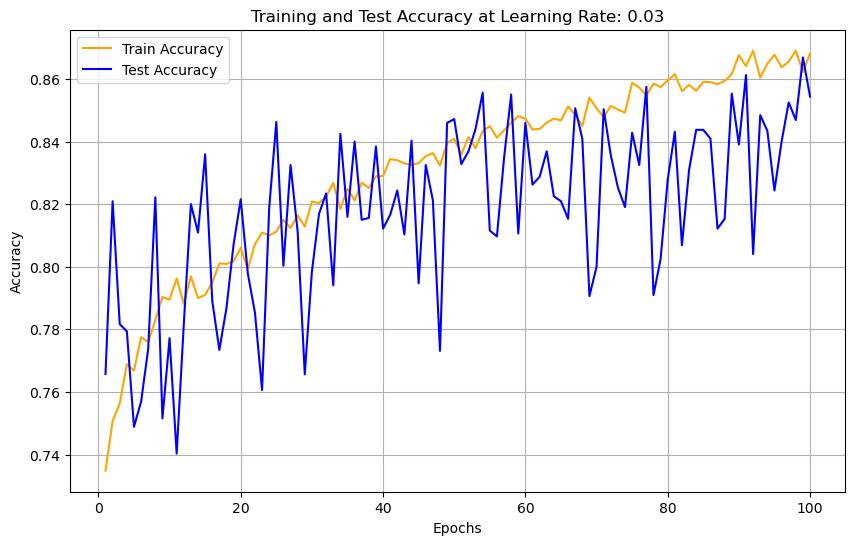

In [49]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6)) 
plt.plot(np.arange(1,101),train_acc_plot, label='Train Accuracy', color='orange')
plt.plot(np.arange(1,101),valid_acc_plot, label='Test Accuracy', color='blue')
plt.title(f'Training and Test Accuracy at Learning Rate: {hparams.learning_rate}')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## Prediction on Evaluation set + Confusion Matrix computation

In [40]:
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
timings=[] 
accuracy,conf_matrix= run_model_eval(model=model_CNN,loader=eval_loader,device=device,timings=timings)
    

print(f'Accuracy: {accuracy * 100:.2f}%')

print('Confusion Matrix:\n', conf_matrix)

all_results_json[-1]['results']['eval_accuracy'] = accuracy
all_results_json[-1]['results']['confusion_matrix'] = conf_matrix.tolist()


Accuracy: 82.00%
Confusion Matrix:
 [[4185  827]
 [ 269  808]]


In [ ]:
import json

filename = './results_models.json'
results_json = json.dumps(all_results_json, indent=4)
with open(filename, 'w') as file:
    file.write(results_json)

print(f"Results have been saved to {filename}")

Results have been saved to ./results_models.json


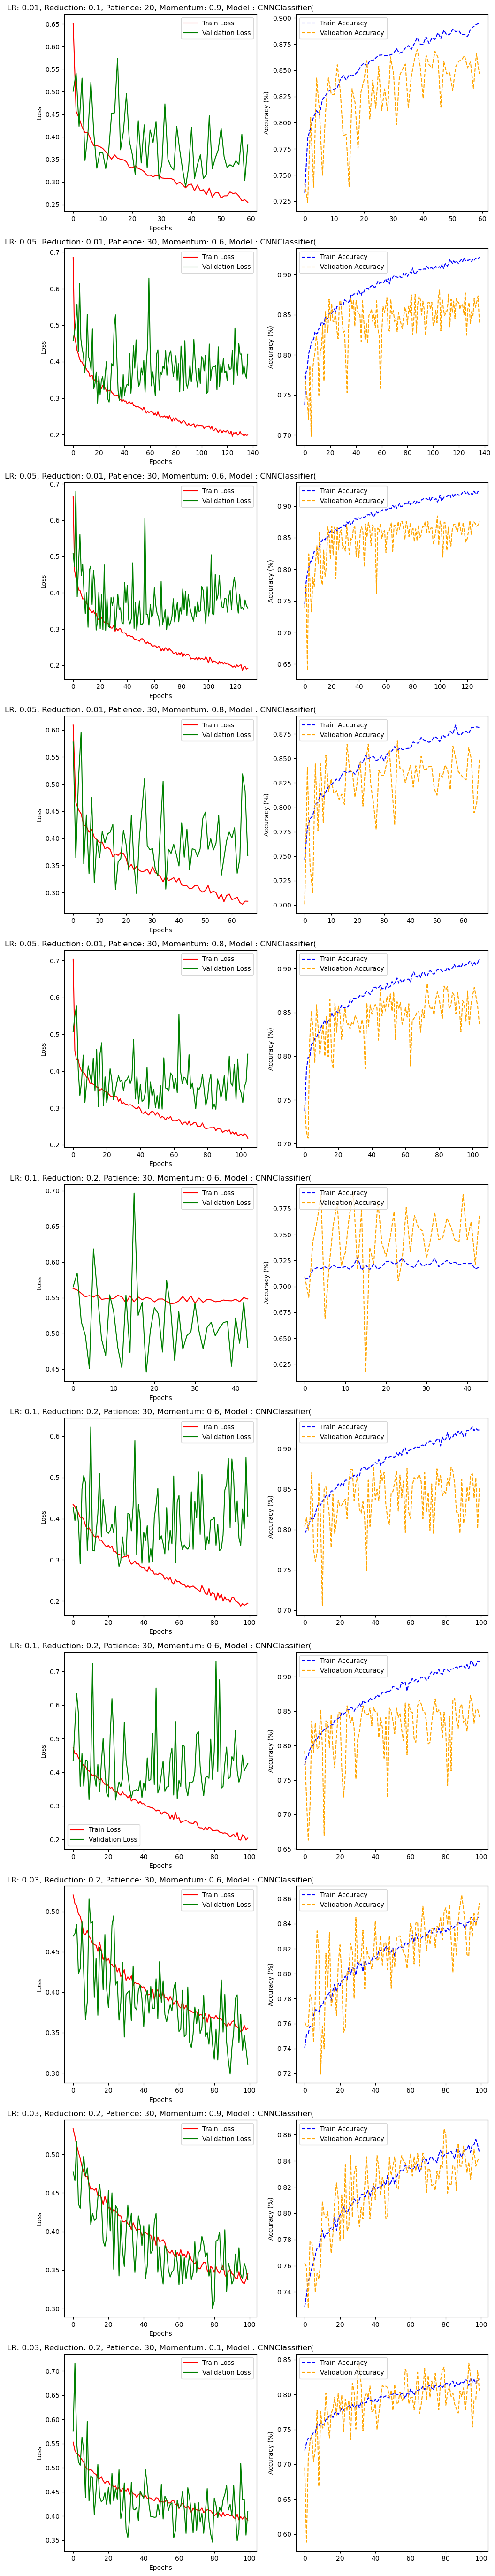

In [44]:
import matplotlib.pyplot as plt


n_rows = len(all_results_json)  
n_cols = 2 
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 5 * n_rows))  

for i, result in enumerate(all_results_json):
    ax = axes[i,0] if n_rows > 1 else axes[0]
    params = result['parameters']
    res = result['results']
    model_name= result['model']['architecture'][0:14]
    
    ax.plot(res['train_loss'], label='Train Loss', color='red')
    ax.plot(res['valid_loss'], label='Validation Loss', color='green')
    
    ax2 = axes[i,1] if n_rows >1 else axes[1] 
    ax2.plot(res['train_accuracy'], label='Train Accuracy', color='blue', linestyle='--')
    ax2.plot(res['valid_accuracy'], label='Validation Accuracy', color='orange', linestyle='--')
    
    title = f"LR: {params['learning_rate']}, Reduction: {params['reduction factor']}, "
    title += f"Patience: {params['patience']}, Momentum: {params['momentum']}, Model : {model_name}"
    ax.set_title(title)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax2.set_ylabel('Accuracy (%)')
    
    # Légendes
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines2, labels2, loc='upper left')
    ax.legend(lines,labels)

plt.tight_layout()

plt.show()
